In this notebook we train a word2vec model on english beer tweets. This gives us clusters in the words, e.g. brewerys or food that people have with their beer. Another application is learning relations between words, e.g. how the word 'warm' is connotated with respect to beer.

In [1]:
import nltk
from nltk.corpus import stopwords
import re
import cPickle as pickle

import commands as cmd

root_path = cmd.getoutput('pwd')[:cmd.getoutput('pwd').find('/databeers/')] + '/databeers'

import sys
sys.path.append(root_path)

In [2]:
from datasketch import MinHash, MinHashLSH


In [3]:
import commands
import csv
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
%matplotlib inline

from src.read_write_utils import *
from src.analysis_utils import *
from src.utils import *

In [4]:

begin_time = datetime(2016, 7, 26)
end_time = datetime(2016, 8, 2)
ta = TweetsAnalysis(begin_time, end_time, root_path)

In [5]:
# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Define a function to split a review into parsed sentences
def tweet_to_sentences(tweet, tokenizer, remove_stopwords=False):
    raw_sentences = tokenizer.tokenize(re.sub("[^A-Za-z0-9 #\,\.]","",tweet.strip()))
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(ta.preprocess_tweet(raw_sentence, "en",
                                                 remove_stopwords=remove_stopwords,
                                                return_string=False))
    
    # Return the list of sentences (each sentence is a list of words)
    # so this returns a list of lists
    return sentences


In [6]:
df = load_joined_df(begin_time, end_time, root_path=root_path, columns = ["text", "id_str", "lang"])
df = df[df["lang_x"] == "en"]

In [7]:
len(df)

742969

In [8]:
import time
def remove_similar_tweets(df, text_col="text", lang_col="lang_x"):
    """
    use local similarity hashing to efficiently remove tweets that are similar to others (might be autogenerated or retweets)
    english tweets only
    """
    t0 = time.time()
    df["tweet_clean"] = np.vectorize(TweetsAnalysis.preprocess_tweet)(df[text_col], df[lang_col])
    tweets = [t.split(" ") for t in df["tweet_clean"]]
    t1 = time.time()
    print t1 - t0, "cleaned tweets"
    lsh = MinHashLSH(threshold=0.4, num_perm=64)  # jaccard similarity 0.6
    idx_selected = {}
    df_indices = df.index.values.tolist()
    for idx, tweet in zip(df_indices, tweets):
        s = MinHash(num_perm=64)
        for word in tweet:
            s.update(word.encode('utf8'))
        # only add if the tweet is not similar to existing ones
        if len(lsh.query(s)) == 0:
            lsh.insert(idx, s)
            idx_selected[idx] = True
    t2 = time.time()
    print t2 - t1, "created lsh"
    # only select the first tweet in a group of similar tweets
    df['select'] = pd.Series([idx_selected.get(idx, False) for idx in df_indices], index=df_indices)
    print df["select"].value_counts()
    t3 = time.time()
    print t3-t2, "selected df"
    return df[df["select"]]

    

In [9]:
filtered_df = remove_similar_tweets(df)

84.9023969173 cleaned tweets
275.732726097 created lsh
False    564821
True     178148
Name: select, dtype: int64
0.35696387291 selected df


In [10]:
len(filtered_df)

178148

In [11]:
sentences = []  # Initialize an empty list of sentences

for tweet in filtered_df["text"]:
    sentences += tweet_to_sentences(tweet, tokenizer)


In [12]:
len(sentences)

249479

In [13]:
# clearing memory
df, filtered_df = 0, 0

In [14]:
with open(root_path + '/sentences_w2v.pickle', 'wb') as handle:
    pickle.dump(sentences, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [8]:
# testread
with open(root_path + '/sentences_w2v.pickle', 'rb') as handle2:
    sentences = pickle.load(handle2)


In [16]:
num_features = 300    # Word vector dimensionality                      
min_word_count = 100   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 5          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec


In [17]:
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)


In [18]:
beer_model = word2vec.Word2Vec([x for x in sentences if "beer" in x], workers=num_workers, 
                               size=num_features, min_count = min_word_count, 
                               window = context, sample = downsampling)


In [19]:
beer_model.most_similar(positive=["piss", "lager"], negative=["bud"])

[('yeast', 0.5835694074630737),
 ('urine', 0.5699260234832764),
 ('flavor', 0.5478398203849792),
 ('fruit', 0.5425886511802673),
 ('bitter', 0.5216475129127502),
 ('belgian', 0.507788896560669),
 ('flat', 0.5002217292785645),
 ('ginger', 0.4920353591442108),
 ('quality', 0.48683205246925354),
 ('scientists', 0.4790954887866974)]

In [20]:
beer_model.most_similar(positive=["good", "warm"], negative=["cold"])

[('bad', 0.6181333065032959),
 ('weird', 0.5318304300308228),
 ('decent', 0.5308865308761597),
 ('expensive', 0.5221172571182251),
 ('fine', 0.5151411890983582),
 ('poor', 0.5103013515472412),
 ('crazy', 0.5054771900177002),
 ('gross', 0.5032286643981934),
 ('nice', 0.4931146800518036),
 ('nasty', 0.49033546447753906)]

In [21]:
model.most_similar(positive=["warm", "better"], negative=["cold"])

[('worse', 0.6821390390396118),
 ('cheaper', 0.6209554076194763),
 ('less', 0.538051962852478),
 ('normal', 0.5059360861778259),
 ('awful', 0.49153298139572144),
 ('higher', 0.48382896184921265),
 ('weird', 0.4610954523086548),
 ('terrible', 0.4531611204147339),
 ('gross', 0.43203145265579224),
 ('tho', 0.43198806047439575)]

In [22]:
model.most_similar("sandwich")

[('fish', 0.9010535478591919),
 ('fries', 0.9007925987243652),
 ('grilled', 0.8725515604019165),
 ('salad', 0.8714592456817627),
 ('pork', 0.8710580468177795),
 ('fried', 0.8653176426887512),
 ('battered', 0.8582631945610046),
 ('steak', 0.8555593490600586),
 ('chips', 0.8515068292617798),
 ('tacos', 0.8359084129333496)]

In [23]:
model.most_similar("lager")

[('gold', 0.8832162618637085),
 ('pilsner', 0.8621751666069031),
 ('pils', 0.8284587860107422),
 ('premium', 0.8269228935241699),
 ('ales', 0.8105338215827942),
 ('helles', 0.8034833073616028),
 ('shandy', 0.7995749115943909),
 ('saison', 0.7972601652145386),
 ('kolsch', 0.7878557443618774),
 ('lion', 0.7866227626800537)]

In [24]:
model.most_similar("bud")

[('coors', 0.8303021192550659),
 ('corona', 0.8207016587257385),
 ('light', 0.7205044031143188),
 ('neon', 0.6744807958602905),
 ('budweiser', 0.6378949880599976),
 ('sign', 0.6322745680809021),
 ('miller', 0.6013752222061157),
 ('anheuserbusch', 0.5521382689476013),
 ('molson', 0.543723464012146),
 ('lite', 0.5217033624649048)]

In [25]:
model.most_similar("pilsner")

[('gold', 0.8819008469581604),
 ('lager', 0.8621751666069031),
 ('pils', 0.8526138067245483),
 ('premium', 0.8329185247421265),
 ('helles', 0.8316840529441833),
 ('bock', 0.817190945148468),
 ('kolsch', 0.8139477968215942),
 ('inn', 0.8129886388778687),
 ('shiner', 0.8103631734848022),
 ('trilliumbrewing', 0.8034617900848389)]

In [26]:
model.most_similar("heineken")

[('anheuserbusch', 0.8508681058883667),
 ('advertising', 0.781387209892273),
 ('draught', 0.7779824733734131),
 ('budweiser', 0.7761120796203613),
 ('ml', 0.7479133605957031),
 ('molson', 0.742904543876648),
 ('#football', 0.7423315048217773),
 ('guinness', 0.738811194896698),
 ('premium', 0.7361233234405518),
 ('#baseball', 0.7231454849243164)]

In [37]:
stops = stopwords.words("english") + ["httpst", "rt", "amp", "#", "https"]

In [38]:
X = np.asarray([a.tolist() for word, a in zip(beer_model.index2word[100:], beer_model.syn0[100:]) if len(word) > 2 and word not in stops])

In [39]:
X.shape

(4169, 300)

In [83]:
[[word, a.tolist()[0]] for word, a in zip(model.index2word, model.syn0) if len(word) > 2 and word not in stops][:10]

[['beer', -0.985146701335907],
 ['drinking', 0.08317756652832031],
 ['#beer', -0.5000413060188293],
 ['like', -1.1770964860916138],
 ['drink', 0.4592191278934479],
 ['get', -0.7273241877555847],
 ['#photo', -0.6828634142875671],
 ['good', -1.210778832435608],
 ['dont', 1.2798086404800415],
 ['one', -1.380395770072937]]

In [40]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=20.0, early_exaggeration=10.0, learning_rate=1000.0, n_iter=400)

In [41]:
projection = tsne.fit_transform(X)

In [210]:

from sklearn.manifold import Isomap
imap = Isomap()
projection2 = imap.fit_transform(model.syn0)

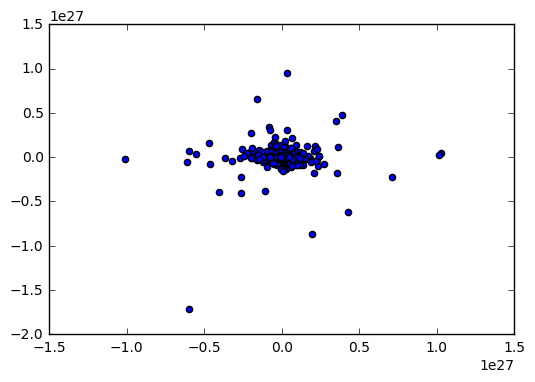

In [42]:
plt.scatter([x[0] for x in projection], [x[1] for x in projection])

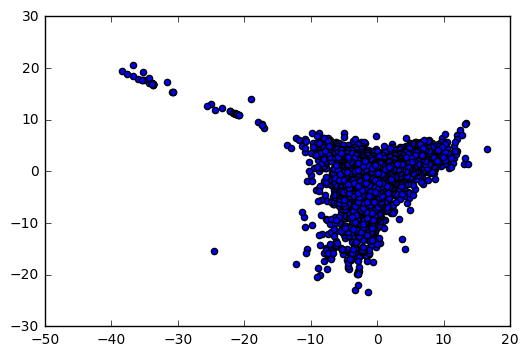

In [211]:
plt.scatter([x[0] for x in projection2], [x[1] for x in projection2])

In [96]:
from sklearn.decomposition import PCA, KernelPCA
m_pca = PCA(n_components=2)

In [93]:
proj_pca = m_pca.fit_transform(X)

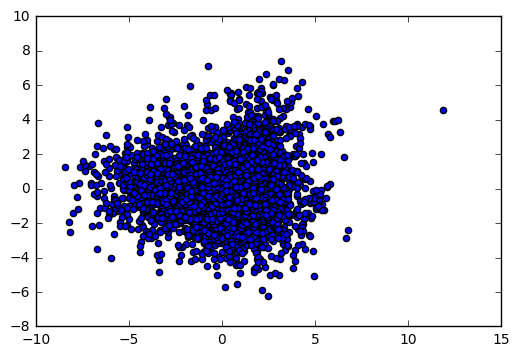

In [95]:
plt.scatter([x[0] for x in proj_pca], [x[1] for x in proj_pca])

In [97]:
k_pca = KernelPCA(n_components=2, kernel='rbf')
proj_k_pca = k_pca.fit_transform(X)

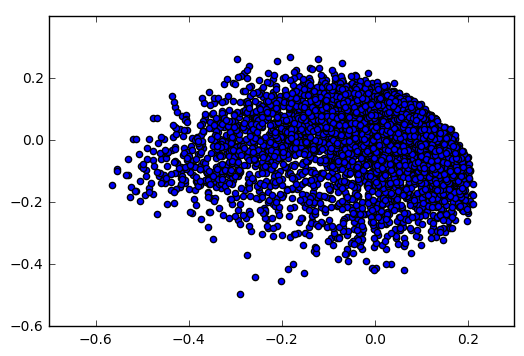

In [98]:
plt.scatter([x[0] for x in proj_k_pca], [x[1] for x in proj_k_pca])

In [232]:
import plotly.plotly as py
import plotly.graph_objs as go

data = [
    go.Scatter(
        x=[x[0] for x in projection][:1500],
        y=[x[1] for x in projection][:1500],
        mode='markers',
        text=[x for x in model.index2word if len(x) > 2][:1500]
    )
]
layout = go.Layout(
    title='T-SNE projection of beer data 500words'
)
fig = go.Figure(data=data, layout=layout)
plot_url = py.plot(fig, filename='word2vec_tsne500words')

In [229]:
py.iplot(fig, filename='word2vec_tsne')

In [212]:
import plotly.plotly as py
import plotly.graph_objs as go

data = [
    go.Scatter(
        x=[x[0] for x in projection2],
        y=[x[1] for x in projection2],
        mode='markers',
        text=model.index2word
    )
]
layout = go.Layout(
    title='T-SNE projection of beer data 20words'
)
fig = go.Figure(data=data, layout=layout)
plot_url = py.plot(fig, filename='word2vec_isomap')

In [218]:
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
projection3 = se.fit_transform(model.syn0)


In [219]:
data = [
    go.Scatter(
        x=[x[0] for x in projection3],
        y=[x[1] for x in projection3],
        mode='markers',
        text=model.index2word
    )
]
layout = go.Layout(
    title='T-SNE projection of beer data 50words'
)
fig = go.Figure(data=data, layout=layout)
plot_url = py.plot(fig, filename='word2vec_spectral_embedding')

In [87]:
py.iplot(fig, filename='hover-chart-basic')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~paulgroundation/0 or inside your plot.ly account where it is named 'hover-chart-basic'


## Get correcations between adjectives and beer brands -> Find the best Beer

In [14]:
# get taste-related adjectives
beer_model.most_similar("disgusting")

[('gross', 0.8989745378494263),
 ('nasty', 0.7869986891746521),
 ('awful', 0.7525091171264648),
 ('horrible', 0.7238757610321045),
 ('terrible', 0.6711565256118774),
 ('weird', 0.6608325242996216),
 ('lame', 0.6300955414772034),
 ('annoying', 0.6132370829582214),
 ('dangerous', 0.5933566689491272),
 ('true', 0.5899311304092407)]

In [65]:
beer_model.most_similar("tasty")

[('delicious', 0.8340697288513184),
 ('yummy', 0.7889936566352844),
 ('refreshing', 0.7690880298614502),
 ('fantastic', 0.6977181434631348),
 ('crisp', 0.6669033765792847),
 ('smooth', 0.6536475419998169),
 ('hoppy', 0.6417926549911499),
 ('fresh', 0.6266703605651855),
 ('solid', 0.6065986156463623),
 ('fruity', 0.6030645370483398)]

In [51]:

def get_clusters_by_rec_similarity(start_word, threshold, cluster=[]):
    cluster += [(start_word, 1)]  # set flag if word was already chosen
    cluster_word_set = set([x[0] for x in cluster])
    cluster += [(x[0], 0) for x in beer_model.most_similar(start_word, topn=100) if x[1] > threshold and 
                x[0] not in cluster_word_set]
    if all([x[1] == 1 for x in cluster]):
        return cluster
    else:
        
        w_idx = [idx for idx, x in enumerate(cluster) if x[1] == 0][0]
        w = cluster.pop(w_idx)
        return get_clusters_by_rec_similarity(w[0], threshold, cluster=cluster)

In [59]:
get_clusters_by_rec_similarity("disgusting", 0.75, cluster=[])

[('disgusting', 1),
 ('gross', 1),
 ('nasty', 1),
 ('awful', 1),
 ('terrible', 1),
 ('horrible', 1)]

In [64]:
get_clusters_by_rec_similarity("tasty", 0.8, cluster=[])

[('tasty', 1), ('delicious', 1)]

## K Means model for clustering

In [66]:
from sklearn.cluster import KMeans

In [90]:
kmeans = KMeans(n_clusters=100)

In [91]:
y = kmeans.fit_predict(beer_model.syn0)

In [93]:
df_kmeans = pd.DataFrame(beer_model.index2word, y).reset_index()

In [94]:
df_kmeans.columns = ["cluster", "word"]

In [95]:
word_clusters = df_kmeans.groupby("cluster")["word"].apply(lambda x: ", ".join(x))

In [96]:
for x in word_clusters:
    print x.split(", "), "---------\n\n-------------"

['drinking', 'having', 'watching', 'playing', 'eating', 'sitting', 'doing', 'enjoying', 'sat', 'drinkin', 'wearing', 'sipping', 'smoking', 'chilling', 'chillin'] ---------

-------------
['cold', 'hand', 'shot', 'pool', 'bed', 'sip', 'shower', 'bong', 'smoke', 'crack', 'gun', 'cigarette', 'bath', 'blunt'] ---------

-------------
['garden', 'beach', 'table', 'side', 'street', 'truck', 'front', 'fire', 'tv', 'lake', 'road', 'train', 'river', 'wall', 'bus', 'boat', 'middle', 'couch', 'patio', 'floor', 'stage', 'porch', 'yard', 'ground', 'chair', 'seat', 'lawn', 'deck', 'roof', 'screen', 'balcony', 'sofa'] ---------

-------------
['been', 'made', 'called', 'done', 'started', 'seen', 'heard', 'lost', 'gone', 'sold', 'spent', 'played', 'paid', 'won', 'needed', 'liked', 'enjoyed', 'forgot', 'loved', 'met', 'stopped', 'named', 'missed', 'added', 'given', 'taken', 'happened', 'realized', 'felt', 'learned', 'kept', 'worked', 'consumed', 'earned', 'arrived', 'changed', 'killed', 'helped', 'gott